In [1]:
# Executing this cell will disable all TQDM outputs in stdout.
import os

os.environ["DISABLE_TQDM"] = "True"

# Computing a LTAS with the Core API [^download]

[^download]: This notebook can be downloaded as **{nb-download}`example_ltas_core.ipynb`**.

Create an **OSEkit** `AudioData` from the files on disk.

There are multiple ways to achieve that, but the most straightforward is to use an ``AudioDataset`` that covers the whole time span of the files by **leaving ``begin``, ``end`` and  ``data_duration`` at the ``None`` default value**.

An `Instrument` can be provided to the `AudioDataset` for the WAV data to be converted in pressure units. This will lead the resulting spectra to be expressed in dB SPL (rather than in dB FS):

In [2]:
from pathlib import Path

audio_folder = Path(r"_static/sample_audio")

from osekit.core_api.audio_dataset import AudioDataset
from osekit.core_api.instrument import Instrument

audio_data = AudioDataset.from_folder(
    folder=audio_folder,
    strptime_format="%y%m%d_%H%M%S",
    instrument=Instrument(end_to_end_db=150.0),
).data[0]

# Resampling at 24 kHz
audio_data.sample_rate = 24_000

The `AudioData` object covers the whole time span of the audio files:

In [3]:
print(f"{' AUDIO DATASET ':#^60}")
print(f"{'Begin:':<30}{str(audio_data.begin):>30}")
print(f"{'End:':<30}{str(audio_data.end):>30}")
print(f"{'Sample rate:':<30}{str(audio_data.sample_rate):>30}")

###################### AUDIO DATASET #######################
Begin:                                   2022-09-25 22:34:50
End:                                     2022-09-25 22:36:50
Sample rate:                                           24000


Instantiate a `scipy.signal.ShortTimeFFT` FFT object with the required parameters:

In [4]:
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hamming

sft = ShortTimeFFT(
    win=hamming(1024),
    hop=128,  # This will be forced to len(win) if we compute a LTAS
    fs=audio_data.sample_rate,
)

Create an **OSEkit** `SpectroDataset` from the `AudioDataset` and the `ShortTimeFFT` objects:

In [5]:
from osekit.core_api.spectro_data import SpectroData

spectro_data = SpectroData.from_audio_data(
    data=audio_data,
    fft=sft,
    v_lim=(0.0, 150.0),  # Boundaries of the spectrogram
    colormap="viridis",  # Default value
)

Checking the required RAM to store the spectrum matrix can give a hint on when to switch to a LTAS computation:

In [6]:
print(f"{' SPECTRO DATA ':#^60}")
print(f"{'Matrix shape:':<30}{str(spectro_data.shape):>30}")
print(f"{'Matrix weight:':<30}{f'{str(round(spectro_data.nb_bytes / 1e6, 2))} MB':>30}")

####################### SPECTRO DATA #######################
Matrix shape:                                   (513, 22507)
Matrix weight:                                     184.74 MB


As displayed, the SX matrix has 22507 time bins.
Let's turn the `SpectroData` object in a `LTASData`, where we will average time bins to force a given x-axis size (`3000` in this example):

In [7]:
from osekit.core_api.ltas_data import LTASData

ltas_data = LTASData.from_spectro_data(
    spectro_data=spectro_data,
    nb_time_bins=3000,
)

The size and weight reduction can be checked:

In [8]:
print(f"{' LTAS DATA ':#^60}")
print(f"{'Matrix shape:':<30}{str(ltas_data.shape):>30}")
print(f"{'Matrix weight:':<30}{f'{str(round(ltas_data.nb_bytes / 1e6, 2))} MB':>30}")

######################## LTAS DATA #########################
Matrix shape:                                    (513, 3000)
Matrix weight:                                      12.31 MB


Now is time to compute the SX values of the LTAS (it can be stored in a variable so that it won't be computed again when plotting or saving them):

In [9]:
ltas_sx = ltas_data.get_value()

We can now plot the LTAS:

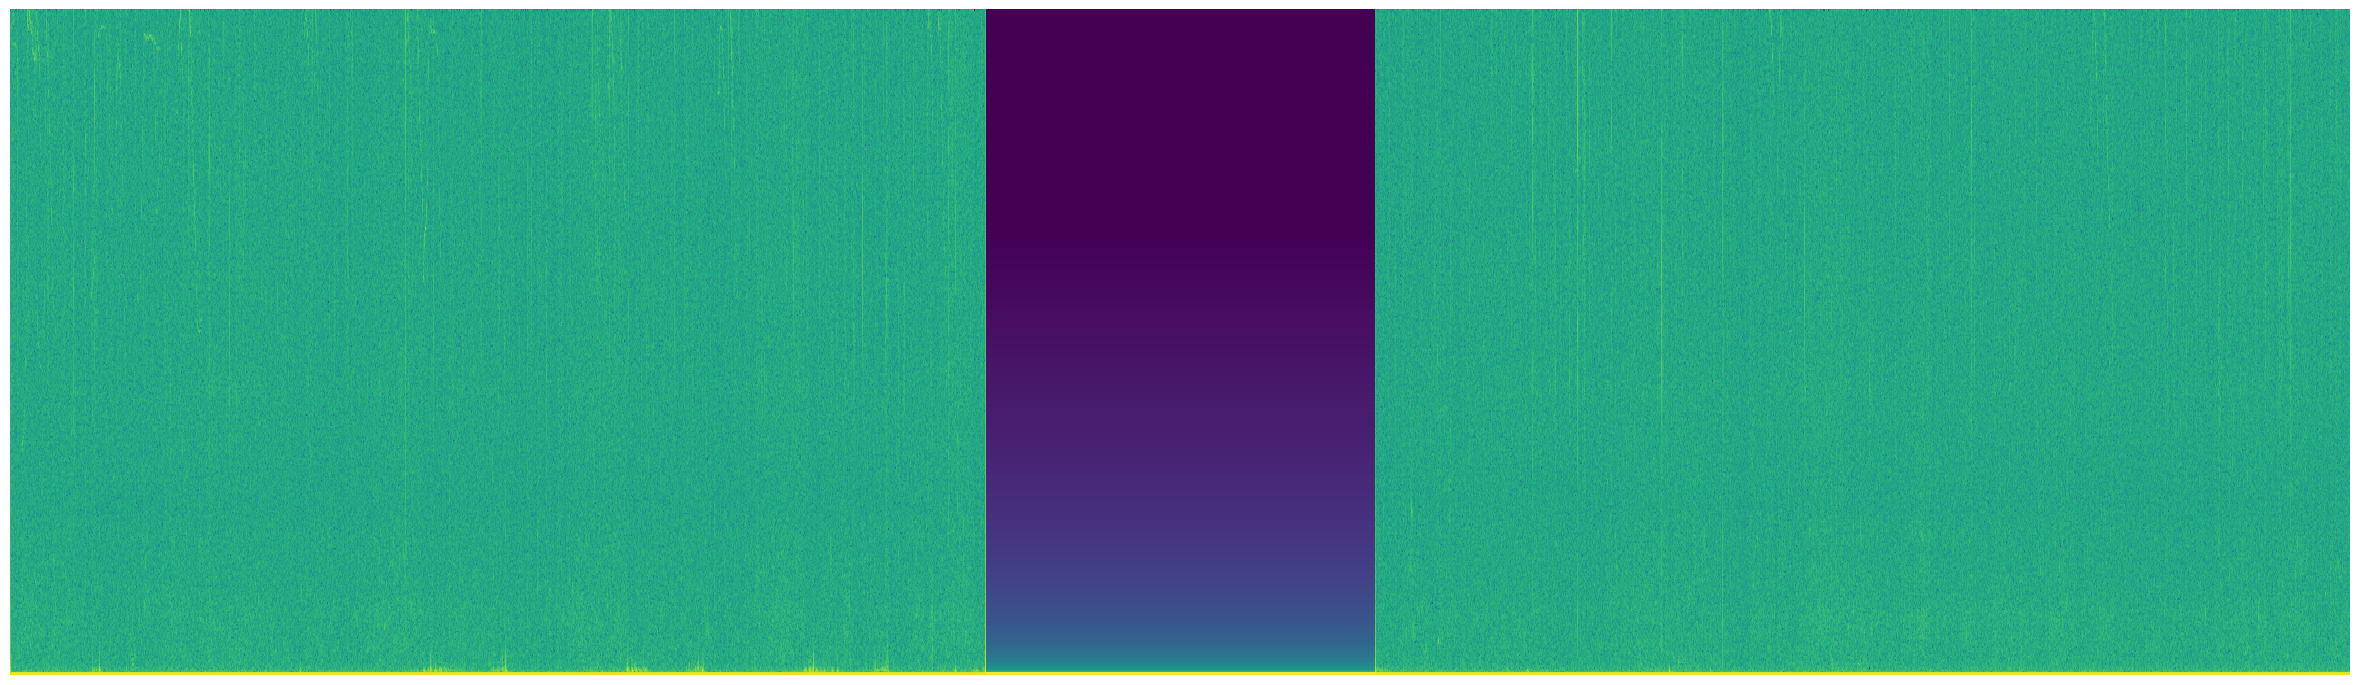

In [10]:
import matplotlib.pyplot as plt

ltas_data.plot(sx=ltas_sx)
plt.show()

The time period in the middle where no audio has been recorded is clearly visible.
Both the spectrogram and the sx matrix can be saved to disk:

In [ ]:
# Export all spectrograms
ltas_data.save_spectrogram(folder=audio_folder / "spectrogram", sx=ltas_sx)

# Export all NPZ matrices
ltas_data.write(folder=audio_folder / "matrix", sx=ltas_sx)